# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [70]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, when, col

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
sns.set()

In [2]:
# Create the spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Customer Churn Prediction") \
    .getOrCreate()

# Load and Clean Dataset
Load the `mini_sparkify_event_data.json` and clean the dataset from invalid/ missing data.

In [3]:
# Load the dataset
events = spark.read.json("mini_sparkify_event_data.json")
events.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [4]:
# Evaluate table schema
events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Check for entries with missing userId
events.filter("userId is Null or userId == ''").show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [6]:
# Investigate auth status of users with missing userId
events.filter("userId is Null or userId == ''").select('auth').distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



In [7]:
# Check, if userId is missing for all entries with the above auth status
events.filter("auth in ('Logged Out','Guest')").select('userId').distinct().show()

+------+
|userId|
+------+
|      |
+------+



In [8]:
# Remove entries for logged out and guest users
events = events.filter("auth not in ('Logged Out', 'Guest')")
print("Entries with missing userId: {}".format(events.filter("userId is Null or userId == ''").count()))

Entries with missing userId: 0


In [9]:
# Check for entries with missing sessionId
print("Entries with missing sessionId: {}".format(events.filter("sessionId is Null or sessionId == ''").count()))

Entries with missing sessionId: 0


In [10]:
# Check for entries with missing ts (timestamp)
print("Entries with missing ts: {}".format(events.filter("ts is Null or ts == ''").count()))

Entries with missing ts: 0


In [11]:
# Check for entries with missing artist
print("Entries with missing artist: {}".format(events.filter("artist is Null or artist == ''").count()))
events.filter("artist is Null or artist == ''").show()

Entries with missing artist: 50046
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|   

In [12]:
events.filter("artist is Null or artist == ''").select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [13]:
# Check unique values of gender
events.select('gender').distinct().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



**Conclusion Data Cleaning**

* Events with the authentication "Logged Out" and "Guest" are not provided with a userId (empty) and therefor have been removed from the dataset.
*Further more, 50046 events with missing artist could be identified. Those entries have been kept though, as they refernece different kinds of user interaction that may not be connected to a single artist (e.g. page == "Upgrade").

# Exploratory Data Analysis

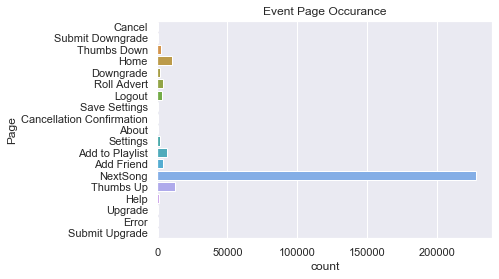

In [43]:
# Count occurance of different event pages 
sns.barplot(x='count', y='Page', data=events.groupby('Page').count().toPandas())
plt.title('Event Page Occurance')
plt.show()

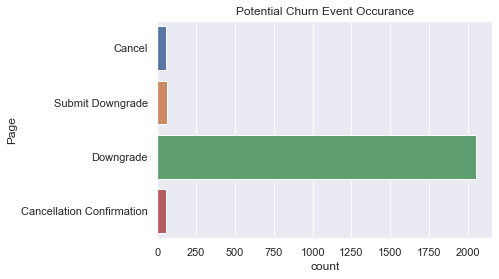

In [44]:
# Count occurance of potential churn events (when user comes to one of the four selected pages)
sns.barplot(x='count', y='Page', data=events.filter("Page in ('Cancel','Cancellation Confirmation','Downgrade', 'Submit Downgrade')").groupby('Page').count().toPandas())
plt.title('Potential Churn Event Occurance')
plt.show()

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [53]:
# Add column churn with 0 as default value
events = events.withColumn("churn", lit(0))
events.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|

In [64]:
# Identify all userIds with churn event
churn_userIds = list(events.filter("Page in ('Cancellation Confirmation','Submit Downgrade')").select('userId').distinct().toPandas()['userId'])

In [73]:
# Set churn to 1 for alle events of a churned user
events = events.withColumn("churn", when(col("userId").isin(churn_userIds), 1).otherwise(col("churn")))
events.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    1|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|

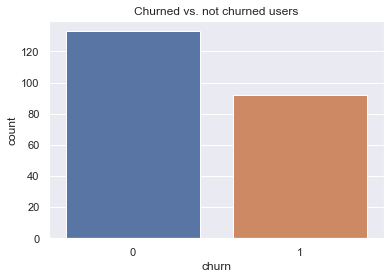

In [81]:
# Check class balance (users who churned vs those who didn't)
sns.barplot(x='churn', y='count', data=events.select(['churn','userId']).distinct().groupby('churn').count().toPandas())
plt.title('Churned vs. not churned users')
plt.show()

**Conclusion Define Chrun**

Churn has been defined as any event that leads the user to the "Cancellation Confirmation" or "Submit Downgrade" page. The "Submit Downgrade" page may not be an equally certain indicator for churn as the "Cancellation Confirmation" page. Anyhow, it still seems like the more valid option compared to the "Downgrade" page, looking at how often this page occurs over all events vs. the occurance of "Cancellation Confirmation" and "Submit Downgrade". Further more, it is assumed that a user, who gets to the "Submit Downgrade" page is more likely to churn, even if he does not actually submits the downgrade just in that moment.


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.